# ASSIGNMENT 3 : Machine Learning Fashionista
## Isaac Schaal

I worked on several parts of this with assignment with Kalia, and recieved help from Josh, the class TA


## Importing and Cleaning

The data sets we were given were folders of images of jerseys and shirts. The data was far from clean and standardized. Several meaures were taken to combat this. Firstly, many images had different background or people in the picture. I decided to only choose images that had a white background. I determined this by checking if the pixel at all four corners was white. Secondly, there were a number of duplicate images in the data set. This calls into question the accuracy of the labels, but we were tasked with using this data set for the assignment. To fix this, I hashed each image and found images that were in both sets. I made a list of these duplicate images and did not import them. Finally, I had to resize each image to be a standard shape. I resized each image to be 150 by 150 pixels so that there are standard dimensions for each image. I then added labels to the data and split it into a training set and test set.

In [8]:
# Imports
import os
from os import listdir
from PIL import Image, ImageFile, ImageOps
import glob
import numpy as np
import matplotlib.pyplot as plt
import hashlib

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

In [9]:
resize_to = (150,150)

# Hash the image
def hash_img(img):
    return hashlib.md5(img).hexdigest()

# Turn the image into an array useable by sklearn
# It is first resized to a standard size and then 
# converted into an array
def img_to_array(img):
    img = img.resize(resize_to)
    img = list(img.getdata())
    img = list(map(list, img))
    img = np.array(img)
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]

# Checks if all four corners of the image are white
def white_background_check(img):
    indexes = [(0,0), (0,img.size[1]-1), (img.size[0]-1,0),
              (img.size[0]-1,img.size[1]-1)]
    pixels = [img.getpixel(index) for index in indexes]
    if pixels == [(255,255,255) for i in range(4)]:
        return True
    else:
        return False

# Check for duplicate images
duplicate_check_jerseys = []
duplicate_check_shirts = []
duplicate_images = []

# Hash each image and put the hash in a list,
# for both jerseys and shirts
for file in glob.glob('Jerseys/*'):
    img_hash = hash_img(open(file, 'rb').read())
    duplicate_check_jerseys.append(img_hash)
    
for file in glob.glob('Shirts/*'):
    img_hash = hash_img(open(file, 'rb').read())
    duplicate_check_shirts.append(img_hash)
    
# See if any images are in both, and record these as duplicates
for file in glob.glob('Jerseys/*') + glob.glob('Shirts/*'):
    img_hash = hash_img(open(file, 'rb').read())
    if img_hash in duplicate_check_jerseys and img_hash in duplicate_check_shirts:
        duplicate_images.append(file)

print ("There are {0} duplicate images".format(len(duplicate_images)))

# Get the non-duplicate, white background images
jerseys = []
for file in glob.glob('Jerseys/*'):
    if file not in duplicate_images:
        img = Image.open(file)
        if white_background_check(img):
            jerseys.append(img_to_array(img))

shirts = []
for file in glob.glob('Shirts/*'):
    if file not in duplicate_images:
        img = Image.open(file)
        if white_background_check(img):
            shirts.append(img_to_array(img))

print ('Out of {0} jerseys, {1} were chosen.'.format( len(glob.glob('Jerseys/*')),
                                                     len(jerseys)))
print ('Out of {0} shirts, {1} were chosen.'.format( len(glob.glob('Shirts/*')),
                                                     len(shirts)))

There are 167 duplicate images
Out of 1332 jerseys, 304 were chosen.
Out of 1470 shirts, 256 were chosen.


In [13]:
# Create labels for the data and split it into training and test
data_and_labels = [(row,'1') for row in jerseys] + [(row,'0') for row in shirts]
data = np.array([x for (x,y) in data_and_labels])
labels = np.array([y for (x,y) in data_and_labels])

X_train, X_test, y_train, y_test = train_test_split(
    data,
    labels,
    test_size = 0.2,
    train_size = 0.8,
    random_state = 1,
    stratify = labels)                                              

## Logistic Regression

The logistic regression was the baseline to compare our other methods to. It was simple to implement, and I did not do any tweaking of parameters to optimize it. The results showed that it produced a semi-accurate model, as it got a 0.69 weighted average on precision and 0.69 weighted average on recall on the test set. However, it can be clearly seen to be overfitting, as it got perfect classification on the training set. 

In [14]:
clf = LogisticRegression(solver = 'liblinear' )
clf.fit(X_train, y_train)

print ("Classification for Training Set:")
print(classification_report(y_train,clf.predict(X_train)))
print ("Classification for Test Set:")
print(classification_report(y_test,clf.predict(X_test)))

Classification for Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       205
           1       1.00      1.00      1.00       243

   micro avg       1.00      1.00      1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448

Classification for Test Set:
              precision    recall  f1-score   support

           0       0.64      0.71      0.67        51
           1       0.73      0.67      0.70        61

   micro avg       0.69      0.69      0.69       112
   macro avg       0.69      0.69      0.69       112
weighted avg       0.69      0.69      0.69       112



## PCA

Principal Component Analysis was my first attempt at dimensionality reduction. The PCA algorithim finds principal components, which are lines in high dimensional space that capture the most amount of variability in the data. A certain number of principal components are found, and then the data is transformed to a score for each principal component ( 1 dimension for each component). This allows for dimensionality reduction while still retaining variability, and is especially usefull for situations where many dimensions have the same value. In our case, things like the background color can be reduced from many dimensions to few. I plotted the top 5 principal components, in the form of their "Eigenshirt", which is a visual representation of the principal component. I also included the opposite of the eigenshirt, which is a representation of the same principal component but on the opposite extreme. I also included the shirts from the data set that best match each eigenshirt and opposite eigenshirt. 

I cross-validated on the number of components in the PCA using grid search. It found the best number of components to be 33. A plot of the mean cross-validated accuracy score for each of the number of components tested is shown below.

I used Logistic Regression on the PCA transformed data, and showed the classification results for both the training and test set.

The PCA method performed better than our initial logistic regression, with an average test score of 0.75 for both precision and recall. We can also see that there was dramaticallty less overfitting with this method, as the training score was much closer to the real test score.

In [15]:
pipe = Pipeline([
    ('pca', PCA()),
    ('clf', LogisticRegression(solver = 'liblinear')),
])

parameters = {
    'pca__n_components': list(range(3,40,3)),
}

# Do 3 way cross validation
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

gs = GridSearchCV(pipe, parameters, cv=kf, n_jobs=-2, verbose=1)

gs.fit(X_train, y_train)

print("Best score: %0.3f" % gs.best_score_)
print("Best parameters set:")
best_parameters = gs.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))   

print ("Classification for Training Set:")
print(classification_report(y_train,gs.predict(X_train)))
print ("Classification for Test Set:")
print(classification_report(y_test,gs.predict(X_test)))

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  39 out of  39 | elapsed:   47.0s finished


Best score: 0.737
Best parameters set:
	pca__n_components: 33
Classification for Training Set:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       205
           1       0.80      0.74      0.77       243

   micro avg       0.76      0.76      0.76       448
   macro avg       0.76      0.76      0.76       448
weighted avg       0.76      0.76      0.76       448

Classification for Test Set:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73        51
           1       0.78      0.75      0.77        61

   micro avg       0.75      0.75      0.75       112
   macro avg       0.75      0.75      0.75       112
weighted avg       0.75      0.75      0.75       112



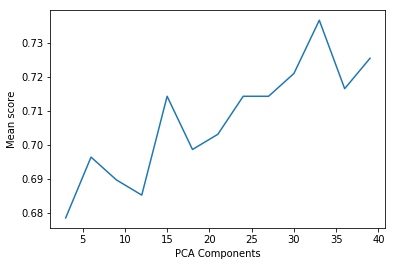

In [16]:
# Plotting the cross-validated score for each number of components
scores = [x for x in list(gs.cv_results_['mean_test_score'])]
scores = np.array(scores)

plt.plot(list(range(3,40,3)), scores)
plt.xlabel('PCA Components')
plt.ylabel('Mean score')
plt.show()



In [17]:
# Showing each principal component as an image
# adapted from https://github.com/graceavery/Eigenstyle/blob/master/visuals.py
def image_from_component_values(component):
    hi = max(component)
    lo = min(component)
    n = int(len(component) / 3)
    divisor = hi - lo
    if divisor == 0:
        divisor = 1
        
    def rescale(x):
        return int(255 * (x - lo) / divisor)
    d = [(rescale(component[3 * i]),
          rescale(component[3 * i + 1]),
          rescale(component[3 * i + 2])) for i in range(n)]
    im = Image.new('RGB', IMAGE_SIZE)
    im.putdata(d)
    return im

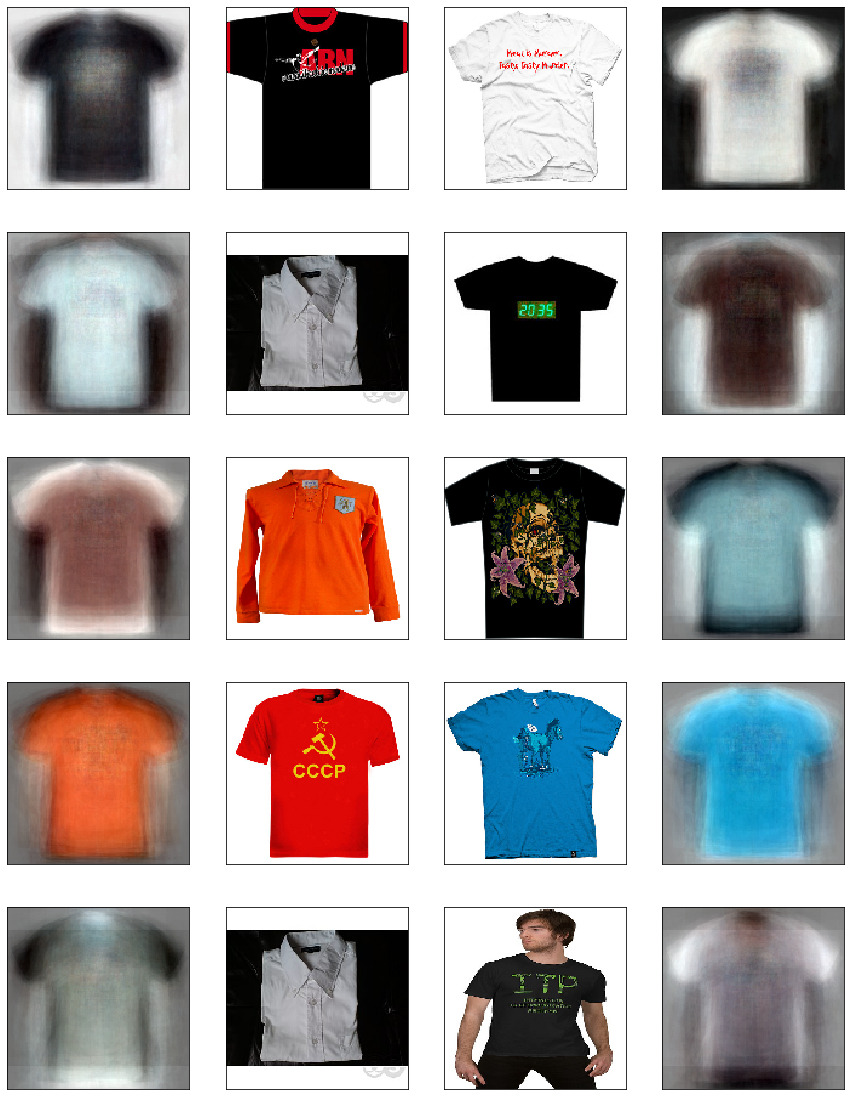

In [18]:
# Fit the PCA onto the training data
pca = PCA(n_components=33, random_state=1)
pca.fit(X_train, y_train)

reduced_X_train = pca.transform(X_train)
pca.inverse_transform(reduced_X_train)

# Create the wrapper figure
fig=plt.figure(figsize=(15, 20))
columns = 4
rows = 5

IMAGE_SIZE = (150,150)

for i in range(1, columns*rows + 1, columns):
    
    # Get the eigen image and the opposite eigen image
    component_id = int(i/columns)
    eigen_image = image_from_component_values(pca.components_[component_id])
    opposite_eigen_image = ImageOps.invert(eigen_image)
    
    # Get the most and least similar images
    similar_id = (np.argmax(reduced_X_train[:, component_id]))
    dissimilar_id = (np.argmin(reduced_X_train[:, component_id]))

    # Print all of the above images in subplots
    fig.add_subplot(rows, columns, i)
    plt.imshow(eigen_image)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    
    fig.add_subplot(rows, columns, i+1)
    similar_image = plt.imshow(
        X_train[similar_id, :].reshape(IMAGE_SIZE[1], IMAGE_SIZE[0], 3))
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    
    fig.add_subplot(rows, columns, i+2)
    similar_image = plt.imshow(
        X_train[dissimilar_id, :].reshape(IMAGE_SIZE[1], IMAGE_SIZE[0], 3))
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    
    fig.add_subplot(rows, columns, i+3)
    plt.imshow(opposite_eigen_image)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)

plt.show()

The above figures show the top 5 principal components, the eigen shirt and the opposite of the eigen shirt, and the shirts from the training set that were the best match. The biggest component was white shirt vs black shirt. There appears to have been a shirt that had a black background (with white bars on top and bottom). It is probably highly irregular in the data and thus was the most extreme shirt for two different components.

## Linear Discriminant Analysis

Linear Discriminant Analysis is another method of dimensionality reduction. It creates new dimensions that maximize the seperation between the two classes. It has an error function that combines maximizing the distance between the means of the two classes and minimizing the variance within a class.

In the sklearn implementation fo LDA, there is no way to cross-validate on the number of dimensions with binary classification, as the maximum number of dimensions is the number of classes -1. 

I fit the model and made predictions on both the training and test set. The score on the test set was worse than both of our previous attempts, with 0.68 for both precision and recall. Not only that, but this model was severely overfitting, as it got almost perfect on the training set.

In [19]:
LDA = LinearDiscriminantAnalysis()
LDA.fit_transform(X_train, y_train)

print ("Classification for Training Set:")
print(classification_report(y_train,LDA.predict(X_train)))
print ("Classification for Test Set:")
print(classification_report(y_test,LDA.predict(X_test)))


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Classification for Training Set:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       205
           1       0.98      0.98      0.98       243

   micro avg       0.98      0.98      0.98       448
   macro avg       0.98      0.98      0.98       448
weighted avg       0.98      0.98      0.98       448

Classification for Test Set:
              precision    recall  f1-score   support

           0       0.64      0.67      0.65        51
           1       0.71      0.69      0.70        61

   micro avg       0.68      0.68      0.68       112
   macro avg       0.68      0.68      0.68       112
weighted avg       0.68      0.68      0.68       112



## Overall Reccommendation

The best method for this data set is the PCA method. Firstly, it gets the best score on the test set. Secondly, it did not overfit (unlike the other two), which is a good sign for the generalizability of the model. LDA performed quite poorly in this test, doing worse than just logistic regression. This may be because it was reducing the images to only one dimension, and that is not a good way to retain variability in the data. We could perhaps see better results from LDA if we had more classes, but in this instance it didn't perform well.